
## **Machine Learning App**

This notebook establishes and subsequently trains a Convolutional Neural Network to classify natural images. 

The dataset has been custom made, starting with the dataset from Kaggle (https://www.kaggle.com/prasunroy/natural-images) and supplemented with additional images in four classifications (airplane, car, cat and dog). The complete dataset can be found at 


*Note: Ensure that your Colab space is running on a GPU by clicking Runtime >> Change runtime type. Ensure Runtime type is Python 3 and Hardware accelerator is GPU.*


Begin by mounting your g-drive into the colab space. The g-drive contains the image dataset to be used in training. This cell will provide a link, follow this link and sign in with your Google account. Copy the authorisation code provided and paste it into the box that appears in the cell below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the necessary libraries. Make note of the Tensorflow, Keras and Numpy version numbers as these must be the same in any environment where the model is subsequently called.

In [ ]:
import os
import zipfile
import random
from shutil import copyfile

%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
import numpy
print(numpy.__version__)
import cv2
print(cv2.__version__)



TensorFlow 1.x selected.
1.15.2
2.3.1
1.19.5


Using TensorFlow backend.


4.1.2


Unzip the Natural Images dataset and load it into the tmp folder of the Colab space.

In [ ]:
CATEGORIES = ["aeroplane", "car", "cat", "dog", "person","flower", "motorbike", "fruit"]

for cat in CATEGORIES: 
  local_zip = '/content/drive/My Drive/ai/' + cat + '.zip'
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/content/drive/My Drive/ai/Dataset')
  zip_ref.close()

Create the necessary folders for training and validation data to be stored.

In [ ]:
try:
    try:
      os.mkdir('/tmp/data')
      os.mkdir('/tmp/data/train')
      os.mkdir('/tmp/data/validation')
      os.mkdir('/tmp/data/test')
    except:
      pass
    for cat in CATEGORIES:
      os.mkdir('/tmp/data/train/' + cat)
      os.mkdir('/tmp/data/validation/' + cat)
      os.mkdir('/tmp/data/test/' + cat)
except OSError as e:
    print(e)

Split the data into training (85%), validation (10%) and test (5%) data.

In [ ]:
def split_data(SOURCE, TRAINING, VALIDATION, TEST, train_size, validation_size):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0.0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * train_size)
    validation_length = int(len(files) * validation_size)
    test_length = int(len(files) - training_length - validation_length)
    
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[training_length:validation_length+training_length-1]
    test_set = shuffled_set[-test_length-1:]
   
      
    if len(files) - len(training_set) - len(validation_set) - len(test_set) > 1:
      print("Split Error!")
      return

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in validation_set:
        this_file = SOURCE + filename
        destination = VALIDATION + filename
        copyfile(this_file, destination)

    for filename in test_set:
        this_file = SOURCE + filename
        destination = TEST + filename
        copyfile(this_file, destination)

train_size = .85
validation_size = 0.1
for cat in CATEGORIES:
    SOURCE_DIR = "/content/drive/My Drive/ai/Dataset/" + cat + "/"
    TRAINING_DIR = "/tmp/data/train/" + cat + "/"
    VALIDATION_DIR = "/tmp/data/validation/" + cat + "/"
    TEST_DIR = "/tmp/data/test/" + cat + "/"

    split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TEST_DIR, train_size, validation_size)

    


aeroplane_1496.png is zero length, so ignoring.
aeroplane_1523.png is zero length, so ignoring.
aeroplane_1844.png is zero length, so ignoring.
aeroplane_1942.png is zero length, so ignoring.
car_0305.png is zero length, so ignoring.
car_0848.png is zero length, so ignoring.


Set the variables required for the model. 

In [ ]:
img_width, img_height = 150, 150


train_data_dir = '/tmp/data/train'
validation_data_dir = '/tmp/data/validation'
test_data_dir = '/tmp/data/test'
epochs = 37
batch_size = 64
classes_count = len(CATEGORIES)

for p in [train_data_dir, validation_data_dir, test_data_dir ]:
  no_of_files = sum([len(files) for r, d, files in os.walk(p)])
  print("%s count: %s" % (p, no_of_files))

nb_train_samples = sum([len(files) for r, d, files in os.walk(train_data_dir)])
nb_validation_samples = sum([len(files) for r, d, files in os.walk( test_data_dir)])

/tmp/data/train count: 18643
/tmp/data/validation count: 3607
/tmp/data/test count: 1893


In order to better train the CNN we use Image Data Generators to manipulate the input images in order to improve the accuracy of the model. The training images will be shifted, sheared, horizontally flipped and zoomed, thus providing a more varied dataset for the model to be trained upon. This is referred to as 'augmenting' the data.

In [ ]:
 from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1. / 255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.02,
    horizontal_flip=True,
    fill_mode='nearest'
    )


# this is the augmentation configuration we will use for validation:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse')

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse') 

Found 18643 images belonging to 8 classes.
Found 3607 images belonging to 8 classes.


Create a Callback function to be used in the training of the model. This will stop training once a pre-defined accuracy threshold (99%) has been achieved.

In [ ]:
tar = 0.99
# Define a Callback class that stops training once accuracy reaches a threshold
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>tar or logs.get('val_accuracy')>tar):
      print("\nReached 99.0% accuracy so cancelling training!")
      self.model.stop_training = True

Define the CNN model, which in this case will be four 2D convolutional layers (with relu activation functions and max pooling enabled). Followed by two fully connected dense layer (with relu activation), a dropout layer (to reduce over fitting) and a final dense layer with a softmax activation function. This final layer will output a one-hot list which represents the model’s designated classification of the image.

An Adam (Adaptive moment estimation) optimizer is used as it works well in practice and outperforms other adaptive techniques.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(64))
model.add(Activation('relu'))


model.add(Dense(classes_count, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

Train the model using the parameters and image generators defined above.

In [ ]:
NAME = "ML_App"

callbacks = myCallback()

# Train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[callbacks])

try:
  model.save_weights('/content/drive/My Drive/ai/' + NAME + '.h6')  # attempts to save in the gdrive
  model.save('/content/drive/My Drive/ai/' + NAME)
  print("model saved in natuaral images")  
except: 
  model.save_weights('/tmp/' + NAME + '.h5')  # saves in the tmp folder if the gdrive fails to connect
  model.save('/tmp/' + NAME)
  print("model saved in tmp")

Epoch 1/37


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


291/291 [==============================] - 127s 436ms/step - loss: 1.1320 - acc: 0.5798 - val_loss: 0.7524 - val_acc: 0.7112
Epoch 2/37
291/291 [==============================] - 125s 431ms/step - loss: 0.6891 - acc: 0.7471 - val_loss: 0.5882 - val_acc: 0.7945
Epoch 3/37
291/291 [==============================] - 125s 430ms/step - loss: 0.5700 - acc: 0.7912 - val_loss: 0.4874 - val_acc: 0.8163
Epoch 4/37
291/291 [==============================] - 125s 429ms/step - loss: 0.4845 - acc: 0.8221 - val_loss: 0.3760 - val_acc: 0.8584
Epoch 5/37
291/291 [==============================] - 125s 430ms/step - loss: 0.4149 - acc: 0.8462 - val_loss: 0.4518 - val_acc: 0.8335
Epoch 6/37
291/291 [==============================] - 125s 429ms/step - loss: 0.3746 - acc: 0.8609 - val_loss: 0.3577 - val_acc: 0.8815
Epoch 7/37
291/291 [==============================] - 124s 426ms/step - loss: 0.3323 - acc: 0.8775 - val_loss: 0.3689 - val_acc: 0.8696
Epoch 8/37
291/291 [==============================] - 124s 

Plot the Training and validation accuracy and the Training and validation loss to observe who the model preformed over successive epochs.

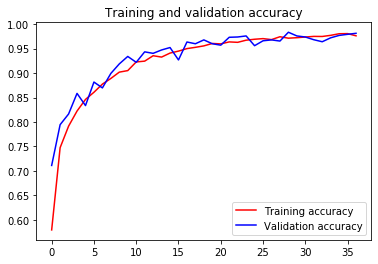

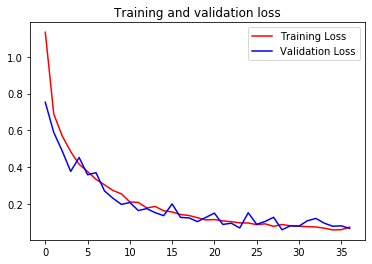

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuraccy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_his = range(len(acc))

plt.plot(epochs_his, acc, 'r', label='Training accuracy')
plt.plot(epochs_his, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_his, loss, 'r', label='Training Loss')
plt.plot(epochs_his, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Run the model on the test data and print a classification report. This gives an indication of the accuracy of the model on images that were not seen during the training / validation of the model. It demonstrates that the model is correct c.96% of the time, although this varies on a class by class basis.

In [ ]:
from sklearn.metrics import classification_report

test_generator = ImageDataGenerator(rescale=1. / 255)
test_data_generator = test_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=8,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

Found 1893 images belonging to 8 classes.


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


              precision    recall  f1-score   support

   aeroplane       0.98      0.99      0.98       209
         car       0.97      0.99      0.98       190
         cat       0.96      0.95      0.96       206
         dog       0.96      0.96      0.96       209
      flower       0.98      0.97      0.98       279
       fruit       0.98      0.98      0.98       398
   motorbike       1.00      0.99      0.99       204
      person       1.00      0.99      1.00       198

    accuracy                           0.98      1893
   macro avg       0.98      0.98      0.98      1893
weighted avg       0.98      0.98      0.98      1893



Upload an example image and test what the model predicts the image is.

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import cv2 


import tensorflow as tf

switch = 1 #Set to 0 if loading directly (i.e. having not immediately trained the model beforehand) 
if switch == 0:
  NAME = "ML_App"
  img_width, img_height = 150, 150 
  CATEGORIES = ["aeroplane", "car", "cat", "dog","person", "motorbike", "flower", "fruit"]
  
def prepare(filepath):
    img_array = cv2.imread(filepath)
    new_array = cv2.resize(img_array, (img_width, img_height))
    new_array_norm = cv2.normalize(new_array, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return new_array_norm.reshape(-1, img_width, img_height, 3)


model = tf.keras.models.load_model('/tmp/' + NAME)
  
uploaded = files.upload()



for fn in uploaded:#.keys():
  prediction = model.predict([prepare(fn)]) 
  print(fn + " is a " + CATEGORIES[np.argmax(prediction[0])])

OSError: ignored